## We now create and run a simple Hello World program using Qiskit
#### The four steps to writing a quantum program using Qiskit patterns are:

##### 1)Map the problem to a quantum-native format.

##### 2)Optimize the circuits and operators.

##### 3)Execute using a quantum primitive function.

##### 4)Analyze the results.


---

### Step-1 Map the problem to a quantum native format
##### In a quantum program, quantum circuits are the native format in which to express the problem, and operators represent the observables to be measured.

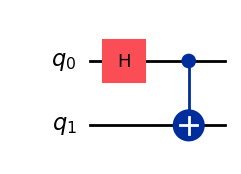

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from matplotlib import pyplot as plt
  
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
qc.draw("mpl")

##### When creating a circuit, we create a new QuantumCircuit object, then add instructions to it in sequence
##### When creating quantum circuits, we have to decide whattype of data we want returned after execution. We can either obtain a probability distribution over the possible outcomes, or we can obtain an expectation value for some observable.

In [2]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

##### Here IZ means the tensor product between I and Z. IZ does nothing to the first qubit and applies a Z-gate to the second qubit. Similarly, ZZ applies a Z-gate to both qubits, also known as (Z-Z) correlation. 

##### In quantum computing, observables are often built from Pauli operators.


---

### Step-2 Optimize the circuits and operators

##### It is important to optimize the set of instructions that the circuit contains and minimize the overall depth of the circuit.
##### This ensure you obtain the best possible results reducing the effect of error and noise.
##### Every IBM quantum device has its own native gate set and qubit connectivity. The circuit's instructions must conform to a backend device's Instruction Set Architecture (ISA) which basically means that the circuit's instructions must be compiled to match the device's native gate set and qubit connectivity.

##### The following code instantiates a real device to submit a job to and transforms the circuit and observables to match that backend's ISA.

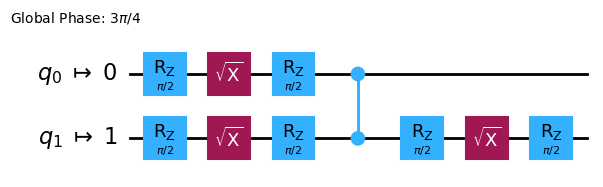

In [3]:
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True) # Get the least busy available backend
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

##### The circuit above is not the original circuit. It is our circuit rewritten in hardware-native gates. IBM hardware uses the basis gates RZ, SX (physical microwave pulse), X, CX. That vertical line connecting q0 and q1 is actually a CX gate. 

##### What we see above is just a map from the logical qubits to the physical hardware qubits. There are different level of optimizatio.
##### Level 0 -> No optimization
##### Level 1 -> Light optimization
##### Level 2 -> Heavy optimization
##### Level 3 -> Heavy optimization with layout optimization


---

### Step-3 Execute using the quantum primitives

##### Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. 
##### You can estimate the value of the observable by using the Estimator class. Estimator is one of two primitives. 
##### The other is Sampler, which can be used to get data (counts) from a quantum computer. 
##### These objects possess a run() method that executes the selection of circuits, observables, and parameters (if applicable), using a primitive unified bloc (PUB).

In [4]:
# Construct the Estimator instance.
 
estimator = Estimator(mode=backend) 
estimator.options.resilience_level = 1 # resilience level 1 applies error mitigation
estimator.options.default_shots = 5000 # number of shots to run
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d6a3j8t7v0is73fo5lp0


#### On real quantum hardware, we cannot directly compute expectation values- we must estimate them from repeated measurements, hence we use estimator primitive.

##### There are different levels of resilience levels
##### Level 0 -> No error mitigation
##### Level 1 -> Error mitigation with readout error mitigation
##### Level 2 -> Error mitigation with readout error mitigation and gate error mitigation
##### Level 3 -> Error mitigation with readout error mitigation, gate error mitigation, and Pauli twirling


##### The mapped_observables ensures that after transpilation, the observables are applied to the correct physical qubits. After transpiltion, the logical quits q0, q1 might become physical qubits q7, q12 (lets say). So if we applied ZZ to q0 and q1, we need to apply ZZ to q7 and q12 in the mapped_observables.

##### apply_layout() fixes this automatically

##### The estimator.run() method runs the circuit. The parameters submitted are one circuit and observables. 
##### The structure [(circuit, observables)] is called one PUB (Primitive Unified Bloc) which is basically a list of tuples.

In [5]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

##### job_result gets the entire result of the job. pub_result gets the result of the first (and only) PUB.

---

### Step-4 Analyze the results

##### this step involves post-processing the results to extract meaningful physical quantities
##### You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general, this step is specific to your problem.

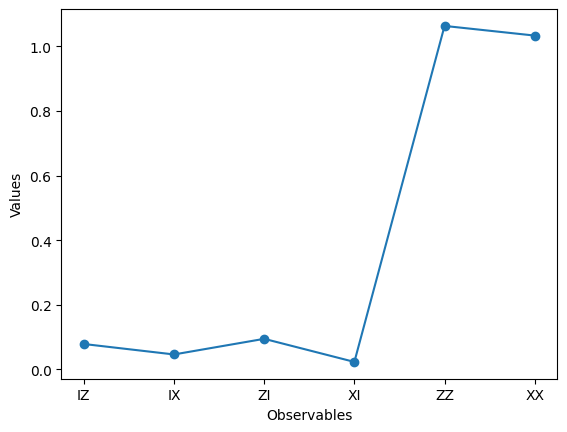

In [6]:
# Plot the result
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

##### Notice that for qubits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (XX and ZZ) are 1. This is a hallmark of quantum entanglement. ZZ and XX value being 1 indicates that the qubits are strongly correlated with no single qubit bias.

##### Individually, each qubit has a 50/50 chance of being 0 or 1, but when measured together, they are always found in the same state.

---

---

## Scale to large numbers of qubits

### Step-1 Map the problem 

##### We create a function that returns a quantum circuit that creates an n-qubit GHZ state. We then use this funtion to prepare a 100-qubit GHZ state and collect the observables to be measured.

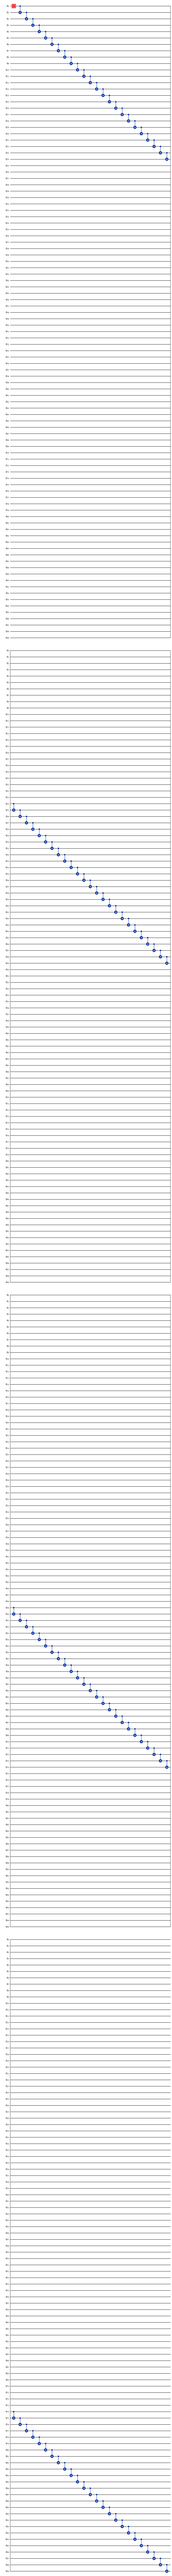

In [8]:
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        n (int): Number of qubits in the n-qubit GHZ state
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n - 1):
            qc.cx(i, i + 1)
    else:
        raise Exception("n is not a valid input")
    return qc
 
 
# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)
qc.draw(output="mpl")

##### For n-qubits, a GHZ state is $$\ket{\text{GHZn}} = \frac{1}{\sqrt{2}} (\ket{0...0} + \ket{1...1})$$

##### All qubits are perfectly correlated.

##### The function checks if n (the number of qubits) is an integer and n should be >= 2

##### Next we map to the operators of interest. 
##### This example uses the ZZ operators between the qubits to examine the behaviour as they get farther apart. 
##### Increasingly inaccurate (corrupted) expectation values between distant qubits would reveal the level of noise present in the system. 

In [4]:
# ZZII...II, ZIZI...II, ... , ZIII...IZ
operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)
]
print(operator_strings)
print(len(operator_strings))
 
operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

---

### Step-2 Optimize the problem for execution on quantum hardware
##### We match the circuit with the backend's ISA (Instruction Set Architecture).

In [12]:
service = QiskitRuntimeService()
 
backend = service.least_busy(
    simulator=False, operational=True, min_num_qubits=100
)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
 
isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]
isa_circuit.draw("mpl", idle_wires=False)

##### The pass manager is basically a pipeline connecting our quantum circuit to the backend with the given optimiation level and backend (quantum computer or simulator). 

##### isa_circuit is the circuit that is created on the backend using the hardware native gates

##### isa_operators_list is the list of operators that are created by mapping the layout of the operators of interest to the hardware layout.

---

### Step-3 Execute on hardware

In [13]:
options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"
 
# Create an Estimator object
estimator = Estimator(backend, options=options)

##### Dynamical decoupling is a method which reduces errors. 
##### In superconductin hardware, the qubits decay even if no gates are applied. The qubits can undergo Qubit Decay (T1 relaxation) or Phases drift (T2 dephasing). 
##### As a result, the quantum state deteriorates. Dynamical decoupling is a method to counteract this by inserting special pulses.

##### Dynamical decoupling is important for our GHZ circuit because the circuit has a long CNOT chain and has idle qubits in between. Dynamial decoupling helps preserve <XXX...X> which is very sensitive to dephasing.

In [14]:
# Submit the circuit to Estimator
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

d6avbfp7ce2c73feph20


---

### Step-4 Post-processing results

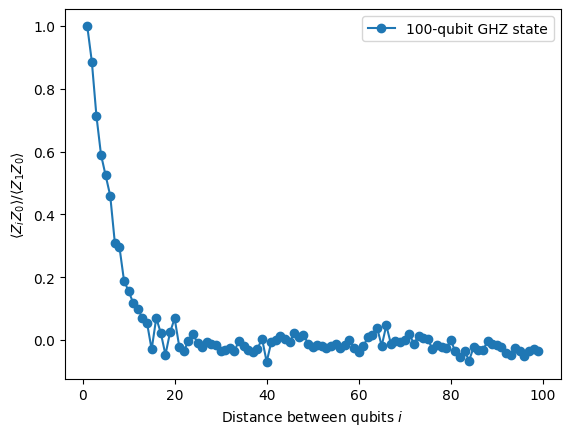

In [15]:
# data
data = list(range(1, len(operators) + 1))  # Distance between the Z operators
result = job.result()[0]
values = result.data.evs  # Expectation value at each Z operator.
values = [
    v / values[0] for v in values
]  # Normalize the expectation values to evaluate how they decay with distance.
 
# plotting graph
plt.plot(data, values, marker="o", label="100-qubit GHZ state")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()

##### The plot shows that as the distance between qubits increases, the signal decays because of the presence of noise.

---